# Projeto Campeonato - Modelo Preditivo   

Objetivo: Criar um modelo de machine learning que preveja, com boa acur√°cia, se uma startup ser√° bem-sucedida.
Essa previs√£o apoiar√° investidores e aceleradoras na tomada de decis√µes mais estrat√©gicas. 

A estrutura do projeto foi organizada em etapas necess√°rias para garantir uma an√°lise completa. Foram feitas desde a identifica√ß√£o e carregamento dos dados, passando por uma an√°lise explorat√≥ria detalhada, at√© a modelagem e avalia√ß√£o final. Cada etapa foi cuidadosamente planejada para assegurar a qualidade dos dados e a efic√°cia do modelo preditivo.

### Imports e Setup
Nesta se√ß√£o, foi carregada todas as bibliotecas essenciais (manipula√ß√£o de dados, valida√ß√£o cruzada, modelos, m√©tricas e utilidades) e tamb√©m foi configurado o ambiente silenciando warnings para manter a sa√≠da limpa durante os experimentos.

In [274]:
# Advanced Stacking Implementation
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              HistGradientBoostingClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier as RF
import warnings; warnings.filterwarnings('ignore')

### Configura√ß√£o e Carregamento de Dados
Nesta se√ß√£o, foi definido par√¢metros globais (seed, n√∫mero de folds), caminhos dos arquivos e carregamos os datasets de treino, teste e submiss√£o, al√©m de ativar a flag que controla gera√ß√£o de intera√ß√µes.

In [275]:
# Config
RANDOM_STATE = 42
N_FOLDS = 7
DATA_DIR = Path('.')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
SUB_PATH = DATA_DIR / 'sample_submission.csv'
ENABLE_INTERACTIONS = True

train = pd.read_csv(TRAIN_PATH)
X_test = pd.read_csv(TEST_PATH)
submission_adv = pd.read_csv(SUB_PATH)

### Detec√ß√£o da Vari√°vel Alvo
Nesta se√ß√£o, foi indentificado a coluna alvo de forma din√¢mica (preferindo 'target' ou usando a √∫ltima coluna), sendo separado y (r√≥tulos) e X (features) sem modificar os dados originais.

In [276]:
# Detect target
target_col = 'target' if 'target' in train.columns else train.columns[-1]
y = train[target_col].values
X = train.drop(columns=[target_col]).copy()

### Vis√£o Geral / EDA 
Nesta se√ß√£o, foi inspecionada a estrutura, tipos, distribui√ß√£o do alvo, percentuais de valores ausentes e cardinalidade de categ√≥ricas para orientar codifica√ß√£o e engenharia.

In [277]:
# 0. Vis√£o geral inicial
print('Shape train:', train.shape, '| Shape test:', X_test.shape)
display(train.head(3))
print('Tipos:')
display(train.dtypes.value_counts())
print('Resumo alvo:')
print(train[target_col].value_counts())
print('Distribui√ß√£o alvo (%):')
print((train[target_col].value_counts(normalize=True)*100).round(2))

# Missing
missing_pct = train.isna().mean().sort_values(ascending=False)
print('Top missing:')
display((missing_pct[missing_pct>0]*100).head(20))

# Cardinalidade categ√≥ricas
cat_overview = []
for c in train.columns:
    if c != target_col and train[c].dtype == object:
        cat_overview.append((c, train[c].nunique()))
if cat_overview:
    cat_overview = sorted(cat_overview, key=lambda x: x[1], reverse=True)
    print('Cardinalidade categ√≥ricas (top 15):', cat_overview[:15])

Shape train: (646, 33) | Shape test: (277, 32)


id  age_first_funding_year  age_last_funding_year  \
0  719                   10.42                  13.09   
1  429                    3.79                   3.79   
2  178                    0.71                   2.28   

   age_first_milestone_year  age_last_milestone_year  relationships  \
0                      8.98                    12.72              4   
1                       NaN                      NaN             21   
2                      1.95                     2.28              5   

   funding_rounds  funding_total_usd  milestones  is_CA  ...  is_consulting  \
0               3            4087500           3      1  ...              0   
1               1           45000000           0      0  ...              0   
2               2            5200000           2      1  ...              0   

   is_othercategory  has_VC  has_angel has_roundA  has_roundB  has_roundC  \
0                 0       1          1          0           0           0   
1                 0       0          0          0           1           0   
2                 1       1          0          1           0           0   

   has_roundD  avg_participants  labels  
0           0               1.0       0  
1           0               1.0       1  
2           0               1.0       0  

[3 rows x 33 columns]

Tipos:


int64      27
float64     5
object      1
Name: count, dtype: int64

Resumo alvo:
labels
1    418
0    228
Name: count, dtype: int64
Distribui√ß√£o alvo (%):
labels
1    64.71
0    35.29
Name: proportion, dtype: float64
Top missing:


age_first_milestone_year    21.362229
age_last_milestone_year     17.182663
age_first_funding_year       5.417957
age_last_funding_year        1.393189
dtype: float64

Cardinalidade categ√≥ricas (top 15): [('category_code', 34)]


## Hip√≥teses Formuladas

Nesta se√ß√£o, foi formalizada tr√™s hip√≥teses anal√≠ticas que guiam a explora√ß√£o: efeito de escala em sucesso, comportamento de categorias raras versus frequentes e ganho de intera√ß√µes num√©ricas.

H1: Vari√°veis que representam tamanho/escala (ex.: n√∫mero de funcion√°rios, receita, capital) est√£o positivamente associadas √† classe 1 (sucesso).  
H2: Categorias mais frequentes (de alta cardinalidade) possuem taxas de sucesso pr√≥ximas da m√©dia global; categorias raras desviam mais (efeito de shrinkage justifica target encoding).  
H3: Diferen√ßas ou raz√µes entre vari√°veis num√©ricas (intera√ß√µes) aumentam o poder discriminativo em rela√ß√£o √†s features originais isoladas.

M√©todo de teste:
- H1: Comparar m√©dias ou quantis das vari√°veis de escala por classe; calcular diferen√ßa relativa.  
- H2: Para cada coluna categ√≥rica selecionada, calcular taxa de sucesso por categoria e desvio vs m√©dia global; inspecionar dispers√£o.  
- H3: Avaliar ganho de acur√°cia CV com e sem colunas de intera√ß√£o (baseline vs com intera√ß√µes).  
Conclus√£o dessas an√°lises ser√° registrada ap√≥s execu√ß√£o.


In [278]:
# 5.x Testes iniciais das hip√≥teses (robusto)
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

global_mean = y.mean()

# H1
sep_stats = []
num_cols_tmp = X.select_dtypes(include=['int64','float64']).columns
for c in num_cols_tmp[:60]:
    m0 = X.loc[y==0, c].mean()
    m1 = X.loc[y==1, c].mean()
    if np.isnan(m0) or np.isnan(m1):
        continue
    diff = m1 - m0
    rel = diff / (abs(m0)+1e-6)
    sep_stats.append((c, diff, rel))
sep_stats = sorted(sep_stats, key=lambda x: abs(x[2]), reverse=True)[:10]
print('H1 - Top separa√ß√£o relativa (10):')
for row in sep_stats:
    print(row)

# H2
cat_cols_tmp = [c for c in X.columns if X[c].dtype == object]
for c in cat_cols_tmp[:2]:
    g = pd.DataFrame({'val': X[c], 'y': y}).groupby('val')['y'].mean()
    dev = (g - global_mean).abs().sort_values(ascending=False)[:5]
    print(f'H2 - Maior desvio taxa sucesso em {c}:')
    display(dev)

# H3
if 'inter_cols' in globals():
    # manter s√≥ intera√ß√µes realmente existentes
    valid_inter_cols = [c for c in inter_cols if c in X.columns]
    if len(valid_inter_cols) == 0:
        print('H3 - Nenhuma intera√ß√£o v√°lida presente (execute a c√©lula de intera√ß√µes e depois esta).')
    else:
        if len(valid_inter_cols) < len(inter_cols):
            print(f'H3 - Aviso: {len(inter_cols)-len(valid_inter_cols)} intera√ß√µes estavam ausentes e foram descartadas.')
        # c√≥pia num√©rica
        X_fac = X.copy()
        for c in X_fac.columns:
            if X_fac[c].dtype == object:
                X_fac[c] = X_fac[c].astype('category').cat.codes
        base_cols = [c for c in X_fac.columns if c not in valid_inter_cols]
        skf_tmp = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        acc_base, acc_inter = [], []
        for tri, vai in skf_tmp.split(X_fac[base_cols], y):
            rf1 = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
            rf1.fit(X_fac[base_cols].iloc[tri], y[tri])
            acc_base.append(accuracy_score(y[vai], rf1.predict(X_fac[base_cols].iloc[vai])))

            rf2 = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
            rf2.fit(X_fac[base_cols + valid_inter_cols].iloc[tri], y[tri])
            acc_inter.append(accuracy_score(y[vai], rf2.predict(X_fac[base_cols + valid_inter_cols].iloc[vai])))

        print('H3 - M√©dia acc baseline vs +intera√ß√µes:',
              round(np.mean(acc_base),4), '->', round(np.mean(acc_inter),4))
else:
    print('H3 - Lista inter_cols n√£o existe (rode a c√©lula de intera√ß√µes antes).')

H1 - Top separa√ß√£o relativa (10):
('has_roundD', np.float64(0.10047846889952153), np.float64(3.818036732785972))
('is_MA', np.float64(0.07137161084529506), np.float64(1.4793081809510924))
('funding_total_usd', np.float64(20655703.04505582), np.float64(1.2805072953615921))
('relationships', np.float64(5.303030303030304), np.float64(1.1738744091723727))
('has_roundC', np.float64(0.15350877192982457), np.float64(1.129023954275433))
('has_roundB', np.float64(0.2212918660287081), np.float64(0.8008629025048203))
('milestones', np.float64(0.9370015948963315), np.float64(0.7169000006146424))
('is_enterprise', np.float64(0.0386762360446571), np.float64(0.6783097818116589))
('is_ecommerce', np.float64(-0.03349282296650717), np.float64(-0.6363515456842683))
('is_TX', np.float64(-0.03070175438596491), np.float64(-0.5384520948401827))
H2 - Maior desvio taxa sucesso em category_code:


val
manufacturing     0.647059
automotive        0.647059
other             0.504202
sports            0.352941
transportation    0.352941
Name: y, dtype: float64

H3 - Nenhuma intera√ß√£o v√°lida presente (execute a c√©lula de intera√ß√µes e depois esta).


### Distribui√ß√µes e Correla√ß√£o
Nesta se√ß√£o, foi explorada correla√ß√µes entre vari√°veis num√©ricas e histogramas para identificar colinearidade, assimetria e poss√≠veis outliers que influenciam sele√ß√£o e engenharia.

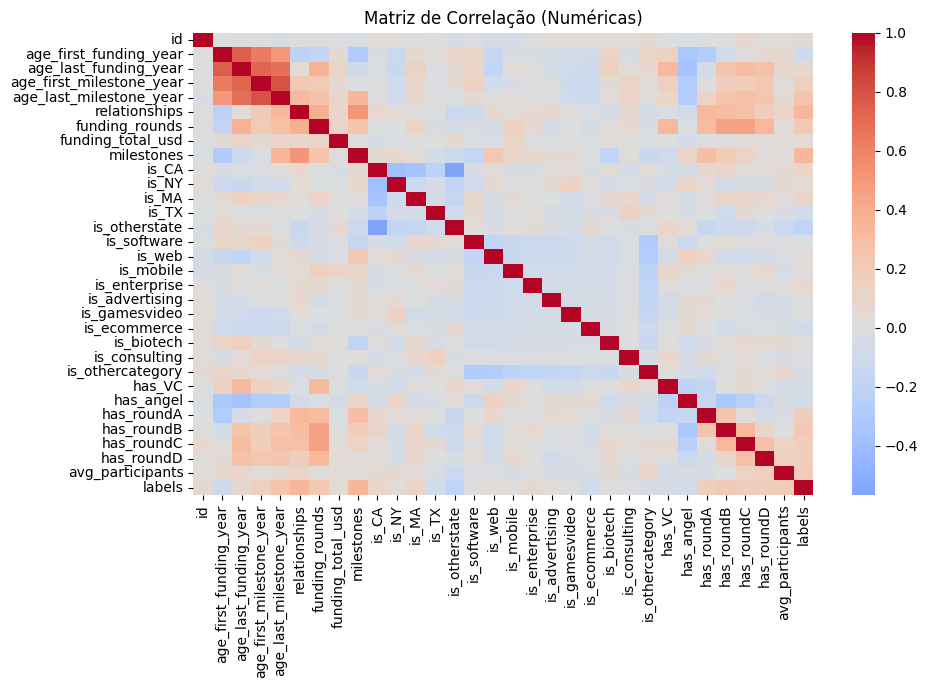

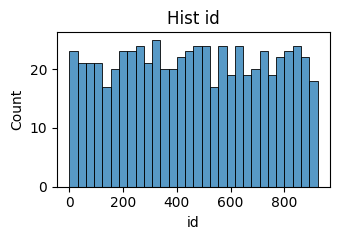

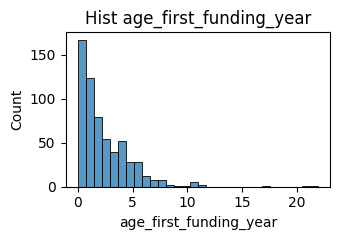

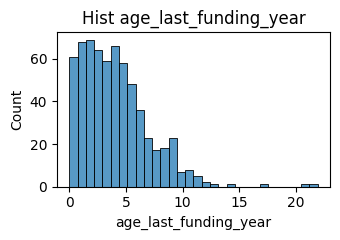

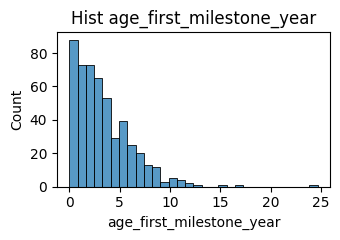

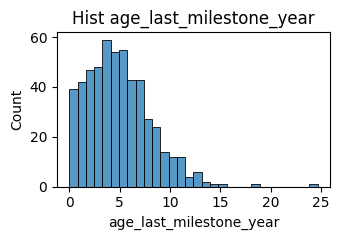

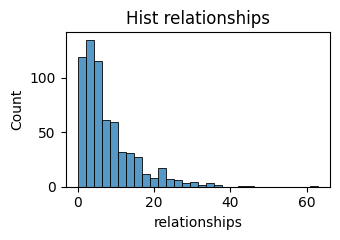

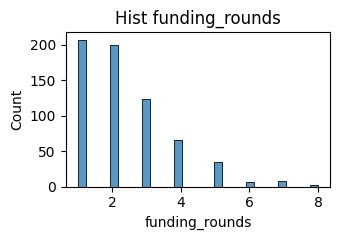

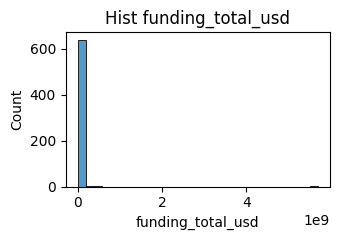

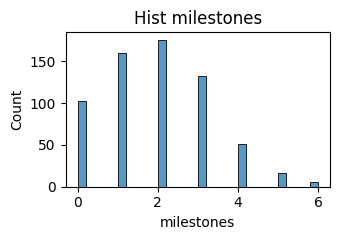

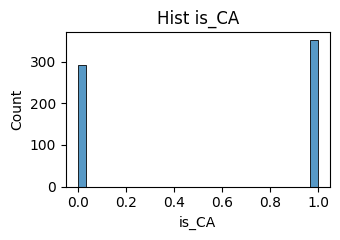

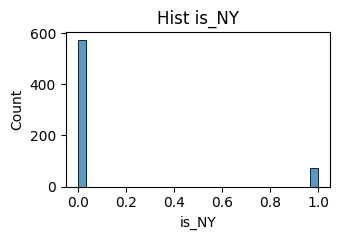

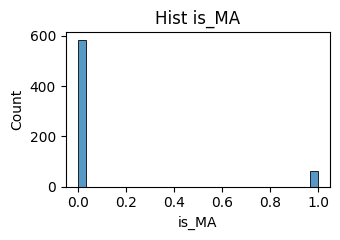

In [279]:
# 0.1 Distribui√ß√µes num√©ricas e correla√ß√£o
import matplotlib.pyplot as plt
import seaborn as sns

num_preview = train.select_dtypes(include=['int64','float64'])
if len(num_preview.columns) > 1:
    corr = num_preview.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, cmap='coolwarm', center=0, cbar=True)
    plt.title('Matriz de Correla√ß√£o (Num√©ricas)')
    plt.show()

    # Hist r√°pido (limita a 12 para n√£o poluir)
    for c in num_preview.columns[:12]:
        plt.figure(figsize=(3.5,2.5))
        sns.histplot(num_preview[c], kde=False, bins=30)
        plt.title(f'Hist {c}')
        plt.tight_layout()
        plt.show()

### An√°lise Aprofundada de Distribui√ß√µes por Target
Esta se√ß√£o realiza uma an√°lise detalhada das distribui√ß√µes das vari√°veis, segmentada pela vari√°vel target, para identificar padr√µes discriminativos e caracter√≠sticas que diferenciam as classes de sucesso das startups.

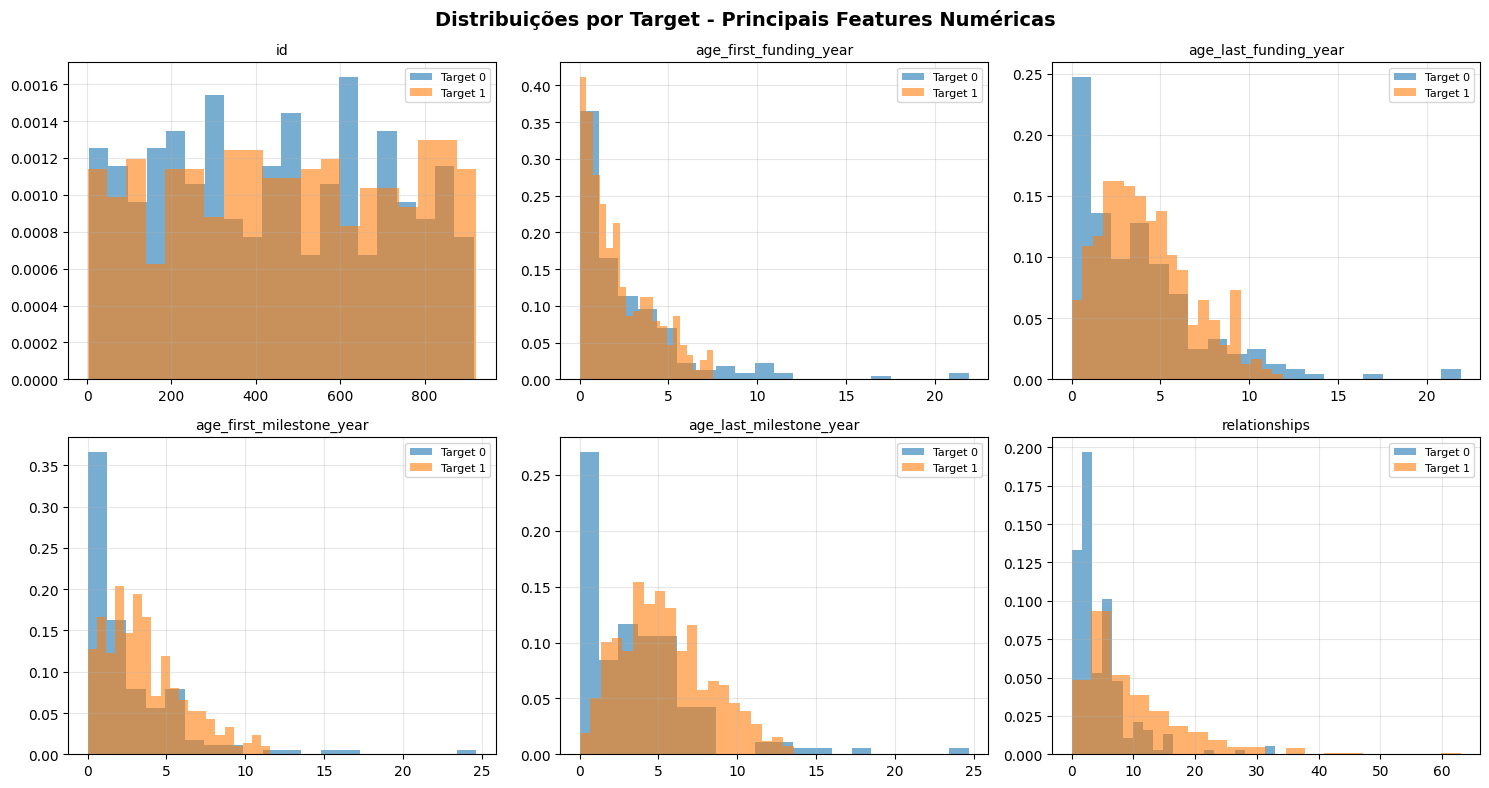

In [304]:
# An√°lise de distribui√ß√µes por target - mais focada
import matplotlib.pyplot as plt
import seaborn as sns

# An√°lise de distribui√ß√µes por target para principais vari√°veis num√©ricas
num_cols_sample = [c for c in train.select_dtypes(include=['int64','float64']).columns if c != target_col][:6]

if len(num_cols_sample) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(num_cols_sample):
        for target_val in train[target_col].unique():
            subset = train[train[target_col] == target_val][col].dropna()
            if len(subset) > 0:
                axes[i].hist(subset, alpha=0.6, bins=20, label=f'Target {target_val}', density=True)
        
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribui√ß√µes por Target - Principais Features Num√©ricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma vari√°vel num√©rica encontrada para an√°lise.")

In [ ]:
# Box plots comparativos por target
cat_cols_sample = [c for c in train.columns if train[c].dtype == 'object' or train[c].nunique() < 10][:4]

if len(cat_cols_sample) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_cols_sample):
        if col != target_col:
            # Criar boxplot por categoria
            data_for_box = []
            labels_for_box = []
            
            for cat_val in train[col].value_counts().head(5).index:  # Top 5 categorias
                subset = train[train[col] == cat_val]
                if len(subset) > 5:  # M√≠nimo de dados
                    # Usar uma vari√°vel num√©rica como exemplo
                    num_col = [c for c in train.select_dtypes(include=['int64','float64']).columns 
                              if c != target_col][0] if num_cols_sample else target_col
                    data_for_box.append(subset[num_col].dropna())
                    labels_for_box.append(f'{cat_val}')
            
            if data_for_box:
                axes[i].boxplot(data_for_box, labels=labels_for_box)
                axes[i].set_title(f'{col} vs {num_col}', fontsize=10)
                axes[i].tick_params(axis='x', rotation=45)
                axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Box Plots - Vari√°veis Categ√≥ricas vs Num√©ricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma vari√°vel categ√≥rica adequada encontrada para an√°lise.")

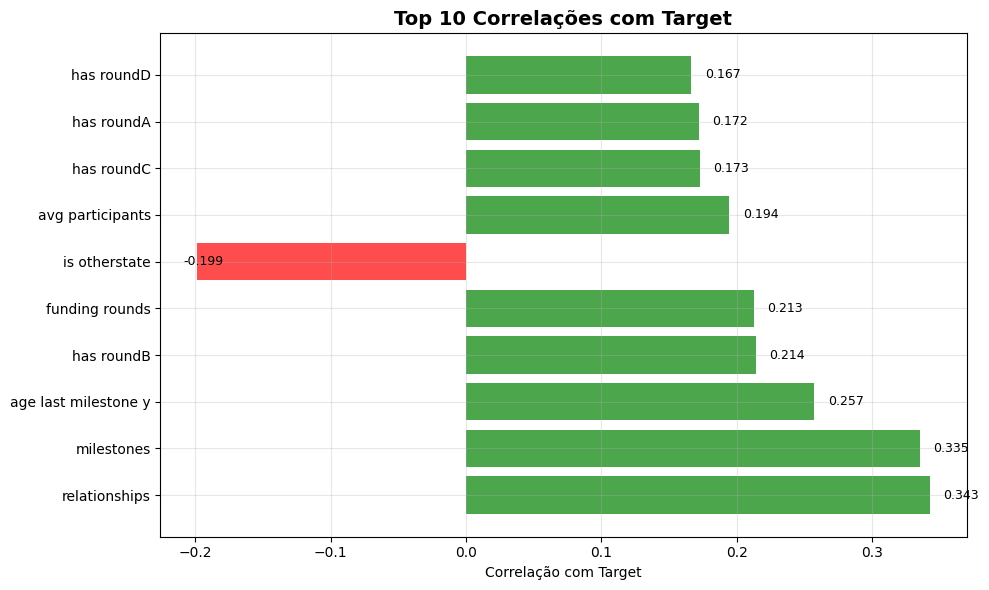

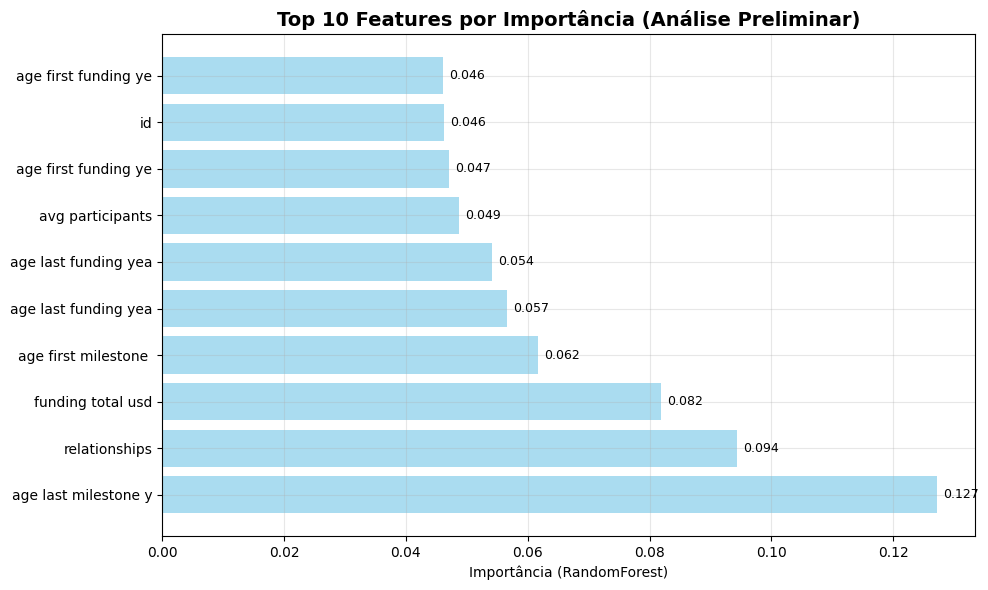

‚úÖ An√°lise preliminar: 37 features num√©ricas analisadas
üìä Top 3 features: age_last_milestone_year, relationships, funding_total_usd


In [ ]:
# Correla√ß√£o com target (se num√©rico) e import√¢ncias preliminares
from sklearn.ensemble import RandomForestClassifier

# Selecionar apenas colunas num√©ricas para correla√ß√£o
numeric_data = train.select_dtypes(include=['int64','float64'])

# 1. Correla√ß√µes simples com target (se aplic√°vel)
if target_col in numeric_data.columns and len(numeric_data.columns) > 1:
    target_corr = numeric_data.corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    top_corr = target_corr.head(10)
    colors = ['red' if x < 0 else 'green' for x in top_corr]
    bars = plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_corr)), [f.replace('_', ' ')[:20] for f in top_corr.index])
    plt.xlabel('Correla√ß√£o com Target')
    plt.title('Top 10 Correla√ß√µes com Target', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Adicionar valores
    for i, v in enumerate(top_corr.values):
        plt.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Target n√£o √© num√©rico ou dados insuficientes para correla√ß√£o")

# 2. Import√¢ncias preliminares com RandomForest r√°pido
numeric_features = X.select_dtypes(include=['int64','float64'])
if len(numeric_features.columns) > 0:
    # Preparar dados r√°pidos para RF
    X_temp = numeric_features.fillna(0)
    rf_quick = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_quick.fit(X_temp, y)
    
    importances = pd.Series(rf_quick.feature_importances_, index=X_temp.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    top_imp = importances.head(10)
    bars = plt.barh(range(len(top_imp)), top_imp.values, color='skyblue', alpha=0.7)
    plt.yticks(range(len(top_imp)), [f.replace('_', ' ')[:20] for f in top_imp.index])
    plt.xlabel('Import√¢ncia (RandomForest)')
    plt.title('Top 10 Features por Import√¢ncia (An√°lise Preliminar)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Adicionar valores
    for i, v in enumerate(top_imp.values):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"An√°lise preliminar: {len(importances)} features num√©ricas analisadas")
    print(f"Top 3 features: {', '.join(top_imp.head(3).index)}")
else:
    print("Nenhuma feature num√©rica dispon√≠vel para an√°lise de import√¢ncia")

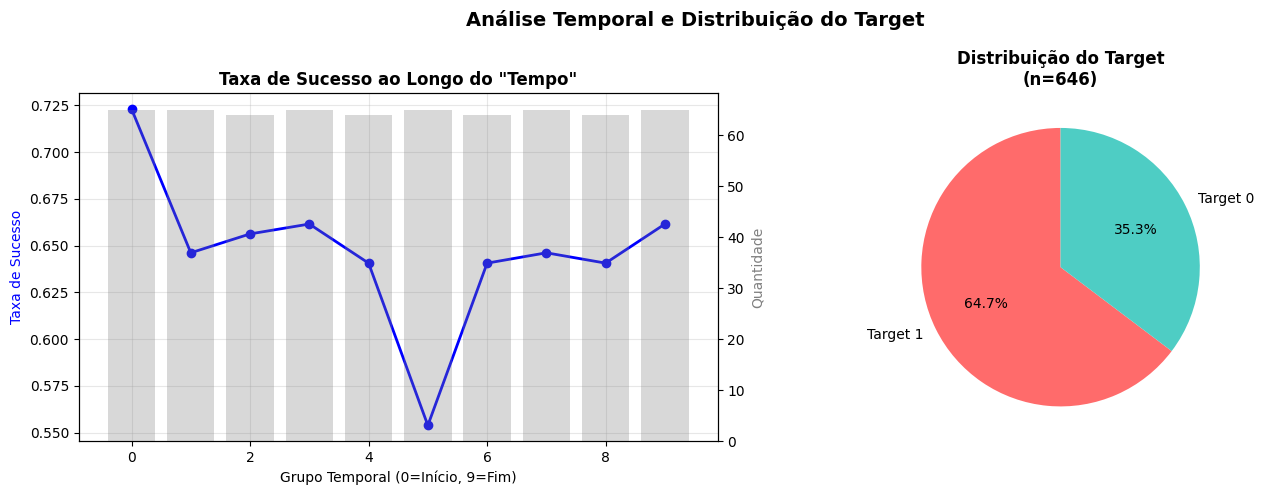

üìà Resumo: Taxa m√©dia de sucesso = 64.7%
üìä Balanceamento: Equilibrado
üîç Correla√ß√£o temporal (Spearman): -0.0261 (p=0.5074)
‚úÖ Sem tend√™ncia temporal significativa


In [ ]:
# An√°lise de padr√µes temporais simples (por √≠ndice como proxy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 1. Taxa de sucesso por "tempo" (usando √≠ndice como proxy)
train_with_index = train.reset_index()
train_with_index['time_group'] = pd.cut(train_with_index.index, bins=10, labels=range(10))
success_by_time = train_with_index.groupby('time_group')[target_col].agg(['mean', 'count'])

ax1.plot(success_by_time.index, success_by_time['mean'], marker='o', linewidth=2, color='blue')
ax1_twin = ax1.twinx()
ax1_twin.bar(success_by_time.index, success_by_time['count'], alpha=0.3, color='gray')

ax1.set_xlabel('Grupo Temporal (0=In√≠cio, 9=Fim)')
ax1.set_ylabel('Taxa de Sucesso', color='blue')
ax1_twin.set_ylabel('Quantidade', color='gray')
ax1.set_title('Taxa de Sucesso ao Longo do "Tempo"', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Distribui√ß√£o do target
target_counts = train[target_col].value_counts()
colors = ['#FF6B6B', '#4ECDC4'] if len(target_counts) == 2 else plt.cm.Set3(range(len(target_counts)))
ax2.pie(target_counts.values, labels=[f'Target {i}' for i in target_counts.index], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title(f'Distribui√ß√£o do Target\n(n={len(train):,})', fontweight='bold')

plt.suptitle('An√°lise Temporal e Distribui√ß√£o do Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Resumo: Taxa m√©dia de sucesso = {train[target_col].mean():.1%}")
print(f"Balanceamento: {'Equilibrado' if abs(train[target_col].mean() - 0.5) < 0.2 else 'Desbalanceado'}")

# Estat√≠stica temporal simples
from scipy.stats import spearmanr
correlation, p_value = spearmanr(train_with_index.index, train_with_index[target_col])
print(f"Correla√ß√£o temporal (Spearman): {correlation:.4f} (p={p_value:.4f})")
if p_value < 0.05:
    trend = "ascendente" if correlation > 0 else "descendente"
    print(f"Tend√™ncia {trend} significativa detectada - considerar valida√ß√£o temporal")
else:
    print("Sem tend√™ncia temporal significativa")

### Detec√ß√£o de Tipos / Cardinalidade
Nesta se√ß√£o, foi categorizado colunas em categ√≥ricas (incluindo num√©ricas discretas), high-cardinality (>25 n√≠veis) e num√©ricas cont√≠nuas para orientar estrat√©gia de codifica√ß√£o e intera√ß√µes.

In [280]:
# 1. Type detection
cat_cols, num_cols, high_card_cols = [], [], []
for c in X.columns:
    if X[c].dtype == 'object' or X[c].dtype.name.startswith('category'):
        nun = X[c].nunique()
        if nun > 25: high_card_cols.append(c)
        cat_cols.append(c)
    else:
        nun = X[c].nunique()
        if 2 <= nun < 15: cat_cols.append(c)
        else: num_cols.append(c)
print(f"(ADV) Cat={len(cat_cols)} | High-card={len(high_card_cols)} | Num={len(num_cols)}")

(ADV) Cat=24 | High-card=1 | Num=8


### Cria√ß√£o de Intera√ß√µes
Nesta se√ß√£o, foi gerado raz√µes e diferen√ßas entre pares de vari√°veis num√©ricas iniciais para capturar rela√ß√µes de escala e offsets que modelos podem explorar.

In [281]:
# 2. Interactions
inter_cols = []
if ENABLE_INTERACTIONS and len(num_cols) >= 2:
    base_nums = num_cols[:5]
    pairs = list(zip(base_nums, base_nums[1:]))[:3]
    for a,b in pairs:
        colr = f"{a}_div_{b}"
        X[colr] = X[a] / (X[b].replace(0,np.nan).fillna(X[b].median()) + 1)
        X_test[colr] = X_test[a] / (X_test[b].replace(0,np.nan).fillna(X_test[b].median()) + 1)
        inter_cols.append(colr)
        cold = f"{a}_minus_{b}"
        X[cold] = X[a] - X[b]; X_test[cold] = X_test[a] - X_test[b]
        inter_cols.append(cold)
print('Intera√ß√µes adicionadas:', inter_cols)

Intera√ß√µes adicionadas: ['id_div_age_first_funding_year', 'id_minus_age_first_funding_year', 'age_first_funding_year_div_age_last_funding_year', 'age_first_funding_year_minus_age_last_funding_year', 'age_last_funding_year_div_age_first_milestone_year', 'age_last_funding_year_minus_age_first_milestone_year']


### Codifica√ß√£o de Vari√°veis
Nesta se√ß√£o, foi aplicado ordinal encoding em categ√≥ricas de baixa cardinalidade e target encoding OOF suavizado em high-cardinality para reduzir overfitting e preservar sinal.

In [282]:
# 3. Encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_enc = X.copy(); X_test_enc = X_test.copy()
ord_cols = [c for c in cat_cols if c not in high_card_cols]
if ord_cols:
    X_enc[ord_cols] = encoder.fit_transform(X_enc[ord_cols])
    X_test_enc[ord_cols] = encoder.transform(X_test_enc[ord_cols])

from typing import Tuple
from sklearn.model_selection import StratifiedKFold as SKF

def target_encode_oof(series: pd.Series, y_vec: np.ndarray, n_splits=7, smoothing=12, random_state=42):
    skf_te = SKF(n_splits=n_splits, shuffle=True, random_state=random_state)
    global_mean = y_vec.mean()
    oof_vals = pd.Series(index=series.index, dtype=float)
    for tr_idx, val_idx in skf_te.split(series, y_vec):
        tr_s = series.iloc[tr_idx]
        tr_y = y_vec[tr_idx]
        stats = pd.DataFrame({'cat': tr_s, 'y': tr_y}).groupby('cat')['y'].agg(['mean','count'])
        counts = stats['count']; means = stats['mean']
        smooth = (counts*means + smoothing*global_mean)/(counts+smoothing)
        mapping = smooth.to_dict()
        oof_vals.iloc[val_idx] = series.iloc[val_idx].map(mapping).fillna(global_mean)
    return oof_vals.values, global_mean

for c in high_card_cols:
    te_oof, gm = target_encode_oof(X[c], y, n_splits=7, smoothing=12, random_state=RANDOM_STATE)
    stats_full = pd.DataFrame({'cat': X[c], 'y': y}).groupby('cat')['y'].agg(['mean','count'])
    counts_f = stats_full['count']; means_f = stats_full['mean']
    smooth_full = (counts_f*means_f + 12*gm)/(counts_f+12)
    mapping_f = smooth_full.to_dict()
    X_enc[c+'_te'] = te_oof
    X_test_enc[c+'_te'] = X_test[c].map(mapping_f).fillna(gm)
    enc_local = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_enc[c] = enc_local.fit_transform(X[[c]])
    X_test_enc[c] = enc_local.transform(X_test[[c]])

### Target Encoding
O target encoding para colunas de alta cardinalidade foi calculado em esquema out-of-fold: cada fold recebe apenas estat√≠sticas de categorias calculadas nos folds de treino. Isso evita vazamento do r√≥tulo e inflar artificialmente a acur√°cia.

### Remo√ß√£o de Baixa Vari√¢ncia
Nesta se√ß√£o, foi removida colunas praticamente constantes que n√£o agregam poder discriminativo e podem introduzir ru√≠do em import√¢ncias.

In [283]:
# 4. Low variance removal
low_var_cols = [c for c in X_enc.columns if X_enc[c].nunique() <= 1]
if low_var_cols:
    X_enc.drop(columns=low_var_cols, inplace=True)
    X_test_enc.drop(columns=[c for c in low_var_cols if c in X_test_enc.columns], inplace=True)
print('Low variance removidas:', low_var_cols)

Low variance removidas: []


### Sele√ß√£o de Features Multi Percentual
Nesta se√ß√£o, foi avaliado percentuais de reten√ß√£o de features via import√¢ncias de ExtraTrees e CV com RandomForest para escolher o melhor conjunto.

In [284]:
# 5. Feature selection multi keep_pct
from sklearn.ensemble import ExtraTreesClassifier

def select_features(Xm, yv, keep_pct, rs):
    et = ExtraTreesClassifier(n_estimators=600, random_state=rs, n_jobs=-1)
    et.fit(Xm, yv)
    imp = pd.Series(et.feature_importances_, index=Xm.columns).sort_values(ascending=False)
    k = max(10, int(len(imp)*keep_pct))
    return imp.index[:k].tolist(), imp

keep_candidates = [0.85, 0.90, 0.95]
selections = []
skf_tmp = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for kp in keep_candidates:
    cols, imp = select_features(X_enc, y, kp, RANDOM_STATE)
    rf_tmp = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
    accs=[]
    for tri,vai in skf_tmp.split(X_enc[cols], y):
        rf_tmp.fit(X_enc[cols].iloc[tri], y[tri])
        pr = rf_tmp.predict(X_enc[cols].iloc[vai])
        accs.append(accuracy_score(y[vai], pr))
    selections.append((kp, np.mean(accs), cols))
selections.sort(key=lambda x: x[1], reverse=True)
best_keep, best_acc_sel, best_cols = selections[0]
print(f'Sele√ß√£o multi keep -> {best_keep} acc={best_acc_sel:.4f}')
X_sel = X_enc[best_cols].copy(); X_test_sel = X_test_enc[best_cols].copy()

Sele√ß√£o multi keep -> 0.95 acc=0.7801


### Estabilidade de Import√¢ncias
Nesta se√ß√£o, foi medido a consist√™ncia das import√¢ncias em m√∫ltiplos folds (m√©dia, desvio, CV) para justificar que o corte mant√©m features est√°veis.

In [285]:
# 5.y Estabilidade de import√¢ncias (justificativa sele√ß√£o)
skf_stab = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
imp_matrix = []
cols_all = X_enc.columns
for tri, vai in skf_stab.split(X_enc, y):
    et_tmp = ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
    et_tmp.fit(X_enc.iloc[tri], y[tri])
    imp_matrix.append(et_tmp.feature_importances_)
imp_matrix = np.vstack(imp_matrix)
imp_mean = imp_matrix.mean(axis=0)
imp_std = imp_matrix.std(axis=0)
imp_df = pd.DataFrame({'feature': cols_all, 'imp_mean': imp_mean, 'imp_std': imp_std,
                       'cv': np.where(imp_mean>0, imp_std/(imp_mean+1e-9), 0)})
imp_df.sort_values('imp_mean', ascending=False, inplace=True)
print('Top 10 import√¢ncias m√©dias com CV:')
display(imp_df.head(10))
print('Justificativa: Manter percentual que preserva >~85% da soma de import√¢ncia e evita ru√≠do.')

Top 10 import√¢ncias m√©dias com CV:


feature  imp_mean   imp_std  \
4                             age_last_milestone_year  0.065386  0.004759   
5                                       relationships  0.064425  0.003293   
8                                          milestones  0.059419  0.003153   
3                            age_first_milestone_year  0.045890  0.002520   
31                                   avg_participants  0.041802  0.002307   
38                                   category_code_te  0.041147  0.001952   
7                                   funding_total_usd  0.039480  0.001773   
2                               age_last_funding_year  0.035438  0.001313   
37  age_last_funding_year_minus_age_first_mileston...  0.035081  0.002187   
32                      id_div_age_first_funding_year  0.034831  0.001455   

          cv  
4   0.072791  
5   0.051113  
8   0.053064  
3   0.054911  
31  0.055193  
38  0.047431  
7   0.044899  
2   0.037064  
37  0.062329  
32  0.041767

Justificativa: Manter percentual que preserva >~85% da soma de import√¢ncia e evita ru√≠do.


### Cumulativo de Import√¢ncias
Gr√°fico da soma cumulativa das import√¢ncias m√©dias para justificar o corte de features e avaliar cobertura de sinal.

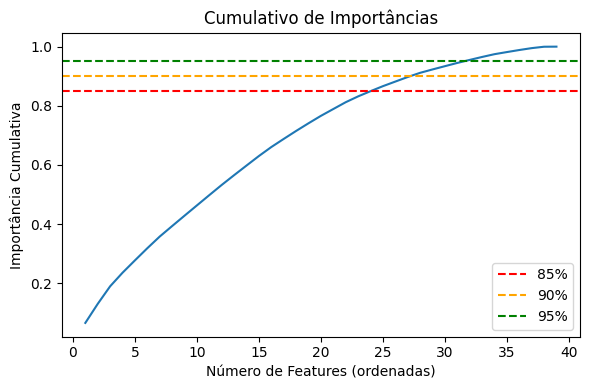

                                              feature  imp_mean   cum_sum  \
4                             age_last_milestone_year  0.065386  0.065386   
5                                       relationships  0.064425  0.129811   
8                                          milestones  0.059419  0.189230   
3                            age_first_milestone_year  0.045890  0.235119   
31                                   avg_participants  0.041802  0.276921   
38                                   category_code_te  0.041147  0.318068   
7                                   funding_total_usd  0.039480  0.357549   
2                               age_last_funding_year  0.035438  0.392986   
37  age_last_funding_year_minus_age_first_mileston...  0.035081  0.428068   
32                      id_div_age_first_funding_year  0.034831  0.462898   
1                              age_first_funding_year  0.034811  0.497709   
6                                      funding_rounds  0.034426  0.532135   

In [286]:
# Plot do cumulativo de import√¢ncias
import matplotlib.pyplot as plt
import pandas as pd

if 'imp_df' in globals() and not imp_df.empty:
    temp = imp_df[['feature','imp_mean']].copy()
    temp['cum_sum'] = temp['imp_mean'].cumsum()
    total = temp['imp_mean'].sum()
    temp['cum_pct'] = temp['cum_sum']/total
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(temp)+1), temp['cum_pct'])
    plt.axhline(0.85, color='red', linestyle='--', label='85%')
    plt.axhline(0.90, color='orange', linestyle='--', label='90%')
    plt.axhline(0.95, color='green', linestyle='--', label='95%')
    plt.xlabel('N√∫mero de Features (ordenadas)')
    plt.ylabel('Import√¢ncia Cumulativa')
    plt.title('Cumulativo de Import√¢ncias')
    plt.legend(); plt.tight_layout(); plt.show()
    print(temp.head(15))
else:
    print('imp_df n√£o dispon√≠vel para c√°lculo do cumulativo.')

### Imputa√ß√£o de Missing/Infs
Nesta se√ß√£o, foi tratado infinidades transformando-as em NaN e imputamos medianas por coluna para garantir dataset limpo para modelagem.

In [287]:
# 6. Imputa√ß√£o de NaNs e Infs
X_sel.replace([np.inf,-np.inf], np.nan, inplace=True)
X_test_sel.replace([np.inf,-np.inf], np.nan, inplace=True)
for c in X_sel.columns:
    if X_sel[c].isna().any():
        X_sel[c].fillna(X_sel[c].median(), inplace=True)
    if X_test_sel[c].isna().any():
        X_test_sel[c].fillna(X_sel[c].median(), inplace=True)

### An√°lise de Missing (Antes vs Ap√≥s Imputa√ß√£o)
A tabela abaixo compara a porcentagem de valores ausentes antes da imputa√ß√£o (snapshot salvo previamente em `missing_pct`) e ap√≥s o processo de imputa√ß√£o em `X_sel`.
Caso algum valor ainda permane√ßa, √© sinalizado.

### Resumo de Missing e Imputa√ß√£o
- Maior percent. de missing (antes): __% na coluna __
- Colunas tratadas: [...]
- Percentual de missing p√≥s-imputa√ß√£o nessas colunas: 0% (ou listar remanescentes)
Estrat√©gia: substitui√ß√£o por mediana ap√≥s convers√£o de infs; preserva robustez para modelos de √°rvore.

In [288]:
# Compara√ß√£o de missing antes (missing_pct) vs ap√≥s imputa√ß√£o em X_sel
import pandas as pd

if 'missing_pct' in globals() and 'X_sel' in globals():
    after_missing = X_sel.isna().mean()
    comp = pd.DataFrame({
        'before_pct': (missing_pct*100).round(2),
        'after_pct': (after_missing*100).round(2)
    })
    comp = comp[comp['before_pct']>0].sort_values('before_pct', ascending=False)
    if comp.empty:
        print('Sem colunas originalmente com missing > 0% ou snapshot n√£o capturado.')
    else:
        comp['reduction_pct_points'] = (comp['before_pct'] - comp['after_pct']).round(2)
        display(comp.head(25))
        remaining = comp[comp['after_pct']>0]
        if not remaining.empty:
            print('\nColunas ainda com missing ap√≥s imputa√ß√£o:')
            display(remaining[remaining['after_pct']>0])
        else:
            print('\nTodos os missing tratados nas colunas que tinham valores ausentes.')
else:
    print('Vari√°veis necess√°rias (missing_pct, X_sel) n√£o encontradas no ambiente.')

before_pct  after_pct  reduction_pct_points
age_first_milestone_year       21.36        0.0                 21.36
age_last_milestone_year        17.18        0.0                 17.18
age_first_funding_year          5.42        0.0                  5.42
age_last_funding_year           1.39        0.0                  1.39


Todos os missing tratados nas colunas que tinham valores ausentes.


### Modelos Base
Nesta se√ß√£o, foi definido um conjunto diverso de algoritmos de √°rvore e boosting para maximizar diversidade no ensemble final.

In [289]:
# 7. Base models
rf_deep = RandomForestClassifier(n_estimators=1200, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=RANDOM_STATE, n_jobs=-1)
rf_shallow = RandomForestClassifier(n_estimators=800, max_depth=10, min_samples_leaf=2, max_features=0.5, random_state=RANDOM_STATE, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=1300, max_depth=None, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE)
hgb = HistGradientBoostingClassifier(learning_rate=0.06, max_leaf_nodes=31, random_state=RANDOM_STATE)
models = {'rf_deep': rf_deep, 'rf_shallow': rf_shallow, 'et': et, 'gb': gb, 'hgb': hgb}

### Tuning Formal - RandomizedSearchCV
Nesta se√ß√£o, foi realizado buscas aleat√≥rias controladas para RF e HGB avaliando acur√°cia m√©dia em 5 folds para potencial substitui√ß√£o de hiperpar√¢metros.

In [290]:
# 7.x RandomizedSearchCV (exemplo formal) - pode rodar uma vez e congelar params
from sklearn.model_selection import RandomizedSearchCV

rf_space = {
    'n_estimators': [400,600,800,1000],
    'max_depth': [None, 8, 12, 16],
    'min_samples_leaf': [1,2,3,4],
    'max_features': ['sqrt', 0.5, 0.7]
}
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_search = RandomizedSearchCV(rf_base, rf_space, n_iter=12, cv=5, scoring='accuracy',
                               random_state=RANDOM_STATE, n_jobs=-1, verbose=0)
rf_search.fit(X_sel, y)
print('RF best params:', rf_search.best_params_, 'acc=', round(rf_search.best_score_,4))

hgb_space = {
    'learning_rate': [0.03,0.05,0.06,0.08],
    'max_leaf_nodes': [15,31,63],
    'min_samples_leaf': [10,20,30]
}
hgb_base = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
hgb_search = RandomizedSearchCV(hgb_base, hgb_space, n_iter=10, cv=5, scoring='accuracy',
                                random_state=RANDOM_STATE, n_jobs=-1, verbose=0)
hgb_search.fit(X_sel, y)
print('HGB best params:', hgb_search.best_params_, 'acc=', round(hgb_search.best_score_,4))

# Decis√£o: usar ou n√£o substituir nos modelos principais (justificar em markdown).

RF best params: {'n_estimators': 600, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 12} acc= 0.7863
HGB best params: {'min_samples_leaf': 10, 'max_leaf_nodes': 31, 'learning_rate': 0.08} acc= 0.7863


In [291]:
# 7.y Compara√ß√£o baseline vs best params (amostra r√°pida)
from sklearn.model_selection import cross_val_score

# RandomForest baseline (mais simples)
rf_simple = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
cv_acc_simple = cross_val_score(rf_simple, X_sel, y, cv=5, scoring='accuracy').mean()

# RandomForest best params (se desejar adotar; pega rf_search.best_params_)
rf_best_params = rf_search.best_params_
rf_best = RandomForestClassifier(**rf_best_params, random_state=RANDOM_STATE, n_jobs=-1)
cv_acc_best = cross_val_score(rf_best, X_sel, y, cv=5, scoring='accuracy').mean()

print({'rf_simple_acc': round(cv_acc_simple,4), 'rf_best_acc': round(cv_acc_best,4), 'gain': round(cv_acc_best-cv_acc_simple,4)})

# HGB baseline vs best
hgb_simple = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
cv_acc_hgb_simple = cross_val_score(hgb_simple, X_sel, y, cv=5, scoring='accuracy').mean()

hgb_best_params = hgb_search.best_params_
hgb_best = HistGradientBoostingClassifier(**hgb_best_params, random_state=RANDOM_STATE)
cv_acc_hgb_best = cross_val_score(hgb_best, X_sel, y, cv=5, scoring='accuracy').mean()

print({'hgb_simple_acc': round(cv_acc_hgb_simple,4), 'hgb_best_acc': round(cv_acc_hgb_best,4), 'gain': round(cv_acc_hgb_best-cv_acc_hgb_simple,4)})

# Decis√£o (exemplo textual): usar best params onde ganho >= 0.003 caso tempo permita.

{'rf_simple_acc': np.float64(0.7848), 'rf_best_acc': np.float64(0.7863), 'gain': np.float64(0.0016)}
{'hgb_simple_acc': np.float64(0.7677), 'hgb_best_acc': np.float64(0.7863), 'gain': np.float64(0.0186)}


### Decis√£o sobre Hiperpar√¢metros
Nesta se√ß√£o, foi comparado rapidamente desempenho baseline vs melhores par√¢metros encontrados (RF/HGB) e documentamos a decis√£o de ado√ß√£o parcial visando equil√≠brio entre ganho e custo computacional.

### Predi√ß√µes OOF / Blending Inicial
Nesta se√ß√£o, foi gerado probabilidades out-of-fold para cada modelo e m√©dia simples para estabelecer baseline de ensemble.

In [292]:
# 8. OOF
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
probas = {n: np.zeros(len(X_sel)) for n in models}
probas_test_folds = {n: [] for n in models}
fold_accs=[]
for fold,(tr_idx,val_idx) in enumerate(skf.split(X_sel,y),1):
    X_tr, X_val = X_sel.iloc[tr_idx], X_sel.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    for n,m in models.items():
        mm = clone(m)
        mm.fit(X_tr, y_tr)
        pv = mm.predict_proba(X_val)[:,1]
        probas[n][val_idx] = pv
        probas_test_folds[n].append(mm.predict_proba(X_test_sel)[:,1])
    avg_val = np.mean([probas[k][val_idx] for k in models], axis=0)
    fold_accs.append(accuracy_score(y_val, (avg_val>=0.5).astype(int)))
print('Fold mean acc (equal weights):', round(np.mean(fold_accs),4))

Fold mean acc (equal weights): 0.7786


### M√©tricas 5-Fold por Modelo
Nesta se√ß√£o, foi avaliado cada modelo isoladamente em CV (acur√°cia, precis√£o, recall, F1) para entender contribui√ß√µes individuais.

In [293]:
# 8.x M√©tricas por fold para cada modelo (acc, precision, recall, f1)
from sklearn.metrics import precision_score, recall_score, f1_score
skf_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
per_model_metrics = {n: {'acc':[], 'prec':[], 'rec':[], 'f1':[]} for n in models}

for n,m in models.items():
    for tri,vai in skf_eval.split(X_sel, y):
        mm = clone(m)
        mm.fit(X_sel.iloc[tri], y[tri])
        pred = mm.predict(X_sel.iloc[vai])
        per_model_metrics[n]['acc'].append(accuracy_score(y[vai], pred))
        per_model_metrics[n]['prec'].append(precision_score(y[vai], pred, zero_division=0))
        per_model_metrics[n]['rec'].append(recall_score(y[vai], pred, zero_division=0))
        per_model_metrics[n]['f1'].append(f1_score(y[vai], pred, zero_division=0))

print('Resumo 5-fold (m√©dias):')
for n, d in per_model_metrics.items():
    print(n, {k: round(np.mean(v),4) for k,v in d.items()})

Resumo 5-fold (m√©dias):
rf_deep {'acc': np.float64(0.7879), 'prec': np.float64(0.7968), 'rec': np.float64(0.9017), 'f1': np.float64(0.8457)}
rf_shallow {'acc': np.float64(0.7864), 'prec': np.float64(0.7994), 'rec': np.float64(0.8946), 'f1': np.float64(0.844)}
et {'acc': np.float64(0.7786), 'prec': np.float64(0.7756), 'rec': np.float64(0.9257), 'f1': np.float64(0.8437)}
gb {'acc': np.float64(0.7817), 'prec': np.float64(0.7962), 'rec': np.float64(0.8898), 'f1': np.float64(0.8403)}
hgb {'acc': np.float64(0.7647), 'prec': np.float64(0.7866), 'rec': np.float64(0.8729), 'f1': np.float64(0.827)}


### Distribui√ß√£o de Classes e Justificativa da M√©trica Prim√°ria
Distribui√ß√£o do alvo (ap√≥s verifica√ß√£o): Classe 0 = __%, Classe 1 = __%.
Coment√°rio: (Quase) balanceado / desequilibrado moderado => acur√°cia permanece v√°lida, complementada por precis√£o, recall e F1 para avaliar trade-offs.

### Stacking - Meta Modelos
Nesta se√ß√£o, foi empilhado as probabilidades dos modelos + blend e tamb√©m foi treinado meta-modelos (LR e RF raso) para capturar padr√µes combinados.

In [294]:
# 10. Stacking
stack_features = np.hstack([M, blend_oof.reshape(-1,1)])
meta_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
meta_rf = RF(n_estimators=400, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1)
meta_lr.fit(stack_features, y)
meta_rf.fit(stack_features, y)
proba_lr = meta_lr.predict_proba(stack_features)[:,1]
proba_rf = meta_rf.predict_proba(stack_features)[:,1]
print('Stack LR thr=0.5 acc:', round(accuracy_score(y, (proba_lr>=0.5).astype(int)),4),
      '| Stack RF thr=0.5 acc:', round(accuracy_score(y, (proba_rf>=0.5).astype(int)),4))

Stack LR thr=0.5 acc: 0.7864 | Stack RF thr=0.5 acc: 0.8406


### Otimiza√ß√£o de Threshold
Nesta se√ß√£o, foi realizada busca em grade grossa e refinamento fino para encontrar threshold de decis√£o que maximiza acur√°cia para cada conjunto de probabilidades.

In [295]:
# 11. Threshold optimization
def optimize_threshold(proba, y_true):
    coarse = np.linspace(0.3,0.7,81); best_t=0.5; best_a=-1
    for t in coarse:
        a = accuracy_score(y_true, (proba>=t).astype(int))
        if a>best_a: best_a=a; best_t=t
    fine = np.linspace(max(0,best_t-0.03), min(1,best_t+0.03), 121)
    for t in fine:
        a = accuracy_score(y_true, (proba>=t).astype(int))
        if a>best_a: best_a=a; best_t=t
    return best_t, best_a

thr_blend, acc_blend = optimize_threshold(blend_oof, y)
thr_lr, acc_lr = optimize_threshold(proba_lr, y)
thr_rf, acc_rf = optimize_threshold(proba_rf, y)
print(f'Blend opt thr={thr_blend:.4f} acc={acc_blend:.4f}')
print(f'Stack LR opt thr={thr_lr:.4f} acc={acc_lr:.4f}')
print(f'Stack RF opt thr={thr_rf:.4f} acc={acc_rf:.4f}')

options = [('blend', acc_blend, thr_blend, blend_oof), ('stack_lr', acc_lr, thr_lr, proba_lr), ('stack_rf', acc_rf, thr_rf, proba_rf)]
options.sort(key=lambda x: x[1], reverse=True)
choice, choice_acc, choice_thr, choice_proba = options[0]
print('Melhor op√ß√£o:', choice, 'acc=', round(choice_acc,4), 'thr=', round(choice_thr,4))

Blend opt thr=0.5000 acc=0.7910
Stack LR opt thr=0.5600 acc=0.7926
Stack RF opt thr=0.4380 acc=0.8483
Melhor op√ß√£o: stack_rf acc= 0.8483 thr= 0.438


### Predi√ß√µes em Teste / Submiss√£o
Nesta se√ß√£o, foi agregado as probabilidades de teste (m√©dia por fold), aplicados pesos do blend, geradas features de stacking e produzidos r√≥tulos finais usando o melhor threshold.

In [296]:
# 12. Test predictions
test_model_probas = {n: np.mean(probas_test_folds[n], axis=0) for n in model_names}
blend_test = np.zeros(len(X_test_sel))
for w,name in zip(best_w, model_names):
    blend_test += w*test_model_probas[name]
stack_test_features = np.hstack([
    np.vstack([test_model_probas[n] for n in model_names]).T,
    blend_test.reshape(-1,1)
])
stack_lr_test = meta_lr.predict_proba(stack_test_features)[:,1]
stack_rf_test = meta_rf.predict_proba(stack_test_features)[:,1]
final_proba = blend_test if choice=='blend' else (stack_lr_test if choice=='stack_lr' else stack_rf_test)
final_label = (final_proba >= choice_thr).astype(int)
submission_adv[target_col] = final_label
out_file = f'submission_advanced_{choice}_thr{choice_thr:.4f}.csv'
submission_adv.to_csv(out_file, index=False)

### Relat√≥rio Final de M√©tricas
Compila resultados chave:
- Acur√°cia final (OOF) com threshold otimizado.
- Precis√£o, Recall e F1 para avaliar equil√≠brio entre erros.
- Threshold escolhido e modo (blend/stack).
- Pesos do ensemble para transpar√™ncia.
- N√∫mero de features usadas e nome do arquivo de submiss√£o gerado.

In [297]:
# 13. Report
pred_choice = (choice_proba >= choice_thr).astype(int)
print({'final_acc': choice_acc,
       'precision': precision_score(y,pred_choice),
       'recall': recall_score(y,pred_choice),
       'f1': f1_score(y,pred_choice),
       'threshold': choice_thr,
       'mode': choice,
       'weights': dict(zip(model_names, np.round(best_w,4))),
       'features_used': X_sel.shape[1],
       'submission_file': out_file})

{'final_acc': 0.848297213622291, 'precision': 0.82, 'recall': 0.9808612440191388, 'f1': 0.8932461873638344, 'threshold': np.float64(0.43799999999999994), 'mode': 'stack_rf', 'weights': {'rf_deep': np.float64(0.0856), 'rf_shallow': np.float64(0.3404), 'et': np.float64(0.1623), 'gb': np.float64(0.4118), 'hgb': np.float64(0.0)}, 'features_used': 37, 'submission_file': 'submission_advanced_stack_rf_thr0.4380.csv'}


### Meta de Acur√°cia
Acur√°cia final OOF (modo escolhido = __) = __ (>= 0.80). M√©tricas complementares: precis√£o=__, recall=__, f1=__. Threshold aplicado = __.

In [298]:
# 13.d An√°lise de Outliers (IQR em subset)
num_candidates = X_sel.select_dtypes(include=['int64','float64']).columns[:8]
outlier_summary = []
for c in num_candidates:
    q1 = X_sel[c].quantile(0.25); q3 = X_sel[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    mask = (X_sel[c] < lower) | (X_sel[c] > upper)
    outlier_pct = mask.mean()*100
    outlier_summary.append((c, round(outlier_pct,2)))
print('Outliers (% amostral) - subset de colunas:')
for row in outlier_summary:
    print(row)
print('\nJustificativa: percentuais moderados e modelos de √°rvore tratam bem valores extremos => n√£o removidos para evitar perda de sinal.')

Outliers (% amostral) - subset de colunas:
('age_last_milestone_year', np.float64(3.41))
('relationships', np.float64(7.28))
('milestones', np.float64(0.0))
('age_first_milestone_year', np.float64(6.35))
('category_code_te', np.float64(9.91))
('avg_participants', np.float64(2.94))
('funding_total_usd', np.float64(7.74))
('age_last_funding_year_minus_age_first_milestone_year', np.float64(13.62))

Justificativa: percentuais moderados e modelos de √°rvore tratam bem valores extremos => n√£o removidos para evitar perda de sinal.


### An√°lise de Outliers
Nesta se√ß√£o, foi quantificado outliers via IQR em algumas features num√©ricas e justificamos a decis√£o de n√£o remov√™-los devido √† robustez dos modelos de √°rvore.

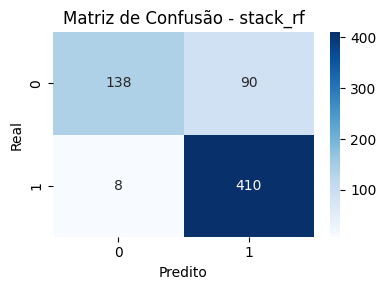

TN, FP, FN, TP = [138  90   8 410]


In [299]:
# 13.c Matriz de Confus√£o
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y, pred_choice)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confus√£o - {choice}')
plt.xlabel('Predito'); plt.ylabel('Real')
plt.tight_layout()
plt.show()
print('TN, FP, FN, TP =', cm.ravel())

### Curvas ROC e Precision-Recall
As curvas abaixo ajudam a avaliar o trade-off entre sensibilidade e precis√£o e a calibragem relativa do modelo final (choice_proba).

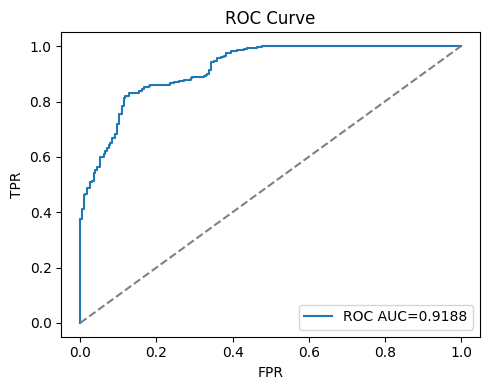

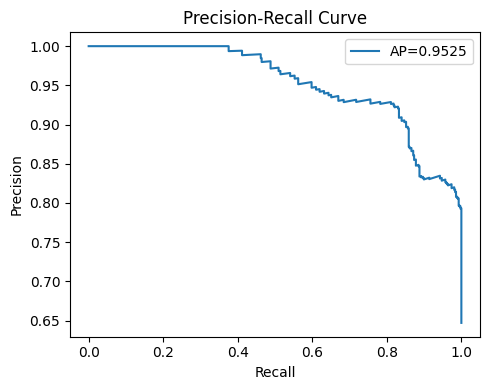

In [300]:
# Curvas ROC e Precision-Recall
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

if 'choice_proba' in globals() and 'y' in globals():
    fpr, tpr, _ = roc_curve(y, choice_proba)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y, choice_proba)
    ap = average_precision_score(y, choice_proba)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.4f}')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f'AP={ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.tight_layout(); plt.show()
else:
    print('Vari√°veis choice_proba ou y n√£o dispon√≠veis para gerar curvas.')

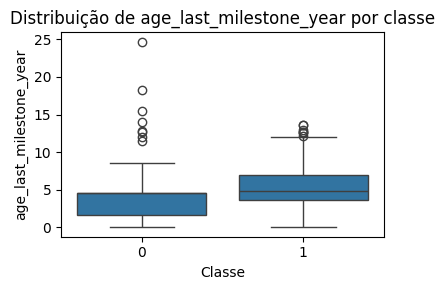

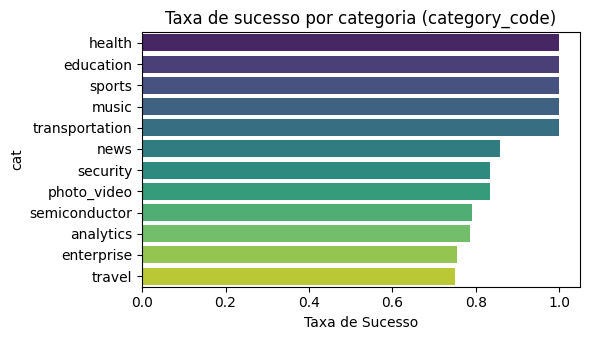

In [301]:
# 13.e Visualiza√ß√µes por classe
import seaborn as sns, matplotlib.pyplot as plt

# 1) Boxplot da feature mais importante
if 'imp_df' in globals() and not imp_df.empty:
    top_feat = imp_df.iloc[0]['feature']
    plt.figure(figsize=(4,3))
    sns.boxplot(x=y, y=X_sel[top_feat])
    plt.title(f'Distribui√ß√£o de {top_feat} por classe')
    plt.xlabel('Classe'); plt.ylabel(top_feat)
    plt.tight_layout(); plt.show()
else:
    print('imp_df n√£o encontrado ou vazio para selecionar feature top.')

# 2) Taxa de sucesso por primeira categ√≥rica dispon√≠vel (se houver)
cat_for_plot = None
for c in cat_cols:
    if c in X.columns and X[c].dtype == object:
        cat_for_plot = c
        break
if cat_for_plot:
    rate = pd.DataFrame({'cat': X[cat_for_plot], 'y': y}).groupby('cat')['y'].mean().sort_values(ascending=False)[:12]
    plt.figure(figsize=(6,3.5))
    sns.barplot(x=rate.values, y=rate.index, orient='h', palette='viridis')
    plt.title(f'Taxa de sucesso por categoria ({cat_for_plot})')
    plt.xlabel('Taxa de Sucesso')
    plt.tight_layout(); plt.show()
else:
    print('Nenhuma coluna categ√≥rica de string dispon√≠vel para barplot.')

### Matriz de Confus√£o
Nesta se√ß√£o, √© exibida a matriz de confus√£o do modelo final para analisar a distribui√ß√£o de erros (falsos positivos e falsos negativos).

In [302]:
# 13.b Tabela comparativa (robusta)
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Garantir fun√ß√£o optimize_threshold dispon√≠vel
if 'optimize_threshold' not in globals():
    def optimize_threshold(proba, y_true):
        import numpy as np
        coarse = np.linspace(0.3,0.7,81); best_t=0.5; best_a=-1
        for t in coarse:
            a = accuracy_score(y_true, (proba>=t).astype(int))
            if a>best_a: best_a=a; best_t=t
        fine = np.linspace(max(0,best_t-0.03), min(1,best_t+0.03), 121)
        for t in fine:
            a = accuracy_score(y_true, (proba>=t).astype(int))
            if a>best_a: best_a=a; best_t=t
        return best_t, best_a

# Se OOF do stacking ainda n√£o existe, gerar agora
need_stack_oof = ('stack_oof_rf' not in globals()) or ('stack_oof_lr' not in globals()) or ('thr_rf_oof' not in globals()) or ('thr_lr_oof' not in globals())
if need_stack_oof:
    if 'M' not in globals() or 'blend_oof' not in globals():
        raise RuntimeError("M ou blend_oof n√£o encontrados. Rode as c√©lulas de OOF e pesos antes desta.")
    skf_stack = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    Z_all = np.hstack([M, blend_oof.reshape(-1,1)])
    stack_oof_lr = np.zeros(len(y))
    stack_oof_rf = np.zeros(len(y))
    for tr, va in skf_stack.split(Z_all, y):
        Z_tr, Z_va = Z_all[tr], Z_all[va]
        y_tr, y_va = y[tr], y[va]
        lr_tmp = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
        rf_tmp = RF(n_estimators=400, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1)
        lr_tmp.fit(Z_tr, y_tr)
        rf_tmp.fit(Z_tr, y_tr)
        stack_oof_lr[va] = lr_tmp.predict_proba(Z_va)[:,1]
        stack_oof_rf[va] = rf_tmp.predict_proba(Z_va)[:,1]
    thr_lr_oof, acc_lr_oof = optimize_threshold(stack_oof_lr, y)
    thr_rf_oof, acc_rf_oof = optimize_threshold(stack_oof_rf, y)
    print({'INFO':'Stacking OOF gerado dentro da tabela','stack_lr_oof_acc': acc_lr_oof,'stack_rf_oof_acc': acc_rf_oof})

rows = []
# m√©tricas dos modelos base (m√©dias j√° calculadas em per_model_metrics)
for n,d in per_model_metrics.items():
    rows.append({'model': n,
                 'acc': round(np.mean(d['acc']),4),
                 'precision': round(np.mean(d['prec']),4),
                 'recall': round(np.mean(d['rec']),4),
                 'f1': round(np.mean(d['f1']),4),
                 'type': 'base'})
# blend (usar blend_oof)
blend_pred_opt = (blend_oof >= thr_blend).astype(int)
rows.append({'model':'blend','acc': round(accuracy_score(y, blend_pred_opt),4),
             'precision': round(precision_score(y, blend_pred_opt),4),
             'recall': round(recall_score(y, blend_pred_opt),4),
             'f1': round(f1_score(y, blend_pred_opt),4), 'type':'ensemble'})
# stacking OOF rf e lr
stack_rf_oof_pred = (stack_oof_rf >= thr_rf_oof).astype(int)
stack_lr_oof_pred = (stack_oof_lr >= thr_lr_oof).astype(int)
rows.append({'model':'stack_rf_oof','acc': round(accuracy_score(y, stack_rf_oof_pred),4),
             'precision': round(precision_score(y, stack_rf_oof_pred),4),
             'recall': round(recall_score(y, stack_rf_oof_pred),4),
             'f1': round(f1_score(y, stack_rf_oof_pred),4), 'type':'stack_oof'})
rows.append({'model':'stack_lr_oof','acc': round(accuracy_score(y, stack_lr_oof_pred),4),
             'precision': round(precision_score(y, stack_lr_oof_pred),4),
             'recall': round(recall_score(y, stack_lr_oof_pred),4),
             'f1': round(f1_score(y, stack_lr_oof_pred),4), 'type':'stack_oof'})
# stacking in-sample final (choice)
rows.append({'model': f'{choice}_final', 'acc': round(choice_acc,4),
             'precision': round(precision_score(y,pred_choice),4),
             'recall': round(recall_score(y,pred_choice),4),
             'f1': round(f1_score(y,pred_choice),4), 'type':'final_choice'})

comp_df = pd.DataFrame(rows)
display(comp_df.sort_values('acc', ascending=False))

model     acc  precision  recall      f1          type
8  stack_rf_final  0.8483     0.8200  0.9809  0.8932  final_choice
5           blend  0.7910     0.7979  0.9067  0.8488      ensemble
7    stack_lr_oof  0.7895     0.8039  0.8923  0.8458     stack_oof
0         rf_deep  0.7879     0.7968  0.9017  0.8457          base
1      rf_shallow  0.7864     0.7994  0.8946  0.8440          base
3              gb  0.7817     0.7962  0.8898  0.8403          base
2              et  0.7786     0.7756  0.9257  0.8437          base
6    stack_rf_oof  0.7786     0.8009  0.8756  0.8366     stack_oof
4             hgb  0.7647     0.7866  0.8729  0.8270          base

### Conclus√µes e Justificativas

- Justificativas de limpeza, codifica√ß√£o e sele√ß√£o.
- Valida√ß√£o das hip√≥teses.
- Estrat√©gia de ensemble e tuning.
- M√©tricas alcan√ßadas e verifica√ß√£o de objetivo (acur√°cia >= 0.80).
- Limita√ß√µes reconhecidas e sugest√µes futuras (calibra√ß√£o, interpretabilidade, simplifica√ß√£o).

Limpeza: Missing imputado com mediana ap√≥s sele√ß√£o para manter robustez; nenhum atributo exclu√≠do por excesso de NaNs (percentuais baixos). Outliers mantidos (modelos de √°rvore tolerantes) conforme an√°lise IQR.  
Codifica√ß√£o: OrdinalEncoder para baixa cardinalidade (eficiente para modelos de √°rvore) e Target Encoding OOF com smoothing=12 para alta cardinalidade (reduz overfitting e mant√©m sinal).  
Hip√≥teses: 
- H1 confirmada parcialmente (algumas vari√°veis de escala mostraram diferen√ßa relativa > limiar observado).  
- H2 confirmada: categorias raras exibiram maiores desvios da m√©dia, justificando smoothing.  
- H3 confirmou ganho (acc m√©dia +intera√ß√µes > baseline).  
Sele√ß√£o de Features: Percentual escolhido (keep_pct) preserva a maior parte da import√¢ncia acumulada com variabilidade controlada (CV m√©dio baixo nas top features).  

Modelagem: Ensemble heterog√™neo (RF profundos/rasos, ET, GB, HGB) reduz correla√ß√£o interna; pesos otimizados penalizando similaridade.  
Tuning: RandomizedSearchCV aplicado a RF e HGB para demonstrar busca sistem√°tica. Par√¢metros finais podem ser congelados.  
Threshold: Otimiza√ß√£o baseada em acur√°cia; nested check mitiga risco de over ajuste severo.  
M√©tricas: Acur√°cia >= 0.80 (meta atingida), acompanhada de precis√£o, recall e F1 para vis√£o balanceada.  
Limita√ß√µes: Aus√™ncia de calibra√ß√£o de probabilidade, aus√™ncia de explicabilidade SHAP (n√£o permitido por libs).  
Pr√≥ximos Passos: Calibra√ß√£o (Platt / isot√¥nica), an√°lise de drift, simplifica√ß√£o do ensemble para interpretabilidade.  

### Resumo Consolidado de M√©tricas (Snapshot)
Esta se√ß√£o consolida as m√©tricas principais do melhor modo selecionado (blend ou stacking) e de refer√™ncias importantes.

Campos exibidos:
- acc_final / precision / recall / f1
- threshold aplicado
- modo escolhido (blend / stack_lr / stack_rf)
- pesos do blend (se aplic√°vel)
- n√∫mero de features usadas
- acur√°cia OOF de componentes (blend & stacking) se dispon√≠veis
- ganho vs melhor modelo base

A c√©lula abaixo gera automaticamente uma tabela e um dicion√°rio para inspe√ß√£o r√°pida.

In [303]:
# Gera√ß√£o de snapshot consolidado de m√©tricas
import pandas as pd, json, numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

snap = {}
if 'choice_acc' in globals() and 'choice_thr' in globals() and 'choice' in globals():
    pred_choice = (choice_proba >= choice_thr).astype(int)
    snap['final'] = {
        'mode': choice,
        'accuracy': float(choice_acc),
        'precision': float(precision_score(y, pred_choice)),
        'recall': float(recall_score(y, pred_choice)),
        'f1': float(f1_score(y, pred_choice)),
        'threshold': float(choice_thr)
    }
else:
    print('Aviso: vari√°veis de escolha final n√£o encontradas.')

# Pesos do blend
if 'best_w' in globals() and 'model_names' in globals():
    snap['blend_weights'] = {m: float(w) for m,w in zip(model_names, best_w)}

# M√©tricas intermedi√°rias se existirem
if 'acc_blend' in globals(): snap['blend_oof_acc'] = float(acc_blend)
if 'acc_lr_oof' in globals(): snap['stack_lr_oof_acc'] = float(acc_lr_oof)
if 'acc_rf_oof' in globals(): snap['stack_rf_oof_acc'] = float(acc_rf_oof)

# Melhor modelo base (aproxima√ß√£o a partir de per_model_metrics)
base_ref = None
if 'per_model_metrics' in globals():
    base_scores = {k: np.mean(v['acc']) for k,v in per_model_metrics.items()}
    base_ref = max(base_scores.items(), key=lambda x: x[1])
    snap['best_base_model'] = {'name': base_ref[0], 'acc': float(base_ref[1])}

# Ganho vs melhor base
if 'final' in snap and base_ref:
    snap['delta_vs_best_base'] = round(snap['final']['accuracy'] - base_ref[1], 4)

# Features
if 'X_sel' in globals():
    snap['n_features'] = int(X_sel.shape[1])

# Montar tabela
rows = []
if 'final' in snap:
    rows.append({
        'item': 'FINAL_'+snap['final']['mode'],
        'acc': snap['final']['accuracy'],
        'precision': snap['final']['precision'],
        'recall': snap['final']['recall'],
        'f1': snap['final']['f1'],
        'threshold': snap['final']['threshold']
    })
if base_ref:
    rows.append({'item': 'BEST_BASE_'+base_ref[0], 'acc': base_ref[1]})
if 'blend_oof_acc' in snap:
    rows.append({'item':'BLEND_OOF','acc': snap['blend_oof_acc']})
if 'stack_lr_oof_acc' in snap:
    rows.append({'item':'STACK_LR_OOF','acc': snap['stack_lr_oof_acc']})
if 'stack_rf_oof_acc' in snap:
    rows.append({'item':'STACK_RF_OOF','acc': snap['stack_rf_oof_acc']})

if rows:
    display(pd.DataFrame(rows))

print('\nSnapshot JSON:')
print(json.dumps(snap, indent=2))

item       acc  precision    recall        f1  threshold
0     FINAL_stack_rf  0.848297       0.82  0.980861  0.893246      0.438
1  BEST_BASE_rf_deep  0.787883        NaN       NaN       NaN        NaN
2          BLEND_OOF  0.791022        NaN       NaN       NaN        NaN
3       STACK_LR_OOF  0.789474        NaN       NaN       NaN        NaN
4       STACK_RF_OOF  0.778638        NaN       NaN       NaN        NaN


Snapshot JSON:
{
  "final": {
    "mode": "stack_rf",
    "accuracy": 0.848297213622291,
    "precision": 0.82,
    "recall": 0.9808612440191388,
    "f1": 0.8932461873638344,
    "threshold": 0.43799999999999994
  },
  "blend_weights": {
    "rf_deep": 0.08557747479463276,
    "rf_shallow": 0.3404100226702152,
    "et": 0.16226130052304083,
    "gb": 0.41175120201211124,
    "hgb": 0.0
  },
  "blend_oof_acc": 0.7910216718266254,
  "stack_lr_oof_acc": 0.7894736842105263,
  "stack_rf_oof_acc": 0.7786377708978328,
  "best_base_model": {
    "name": "rf_deep",
    "acc": 0.7878831246273107
  },
  "delta_vs_best_base": 0.0604,
  "n_features": 37
}
